In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [3]:
image_path=r'C:\Users\Yash Sharma\Desktop\project\DATASET\Images'

In [8]:
data = pd.read_csv(r"C:\Users\Yash Sharma\Desktop\project\DATASET\captions.txt", error_bad_lines=False)
data.head()

Skipping line 25: expected 2 fields, saw 4
Skipping line 29: expected 2 fields, saw 3
Skipping line 31: expected 2 fields, saw 3
Skipping line 56: expected 2 fields, saw 5
Skipping line 58: expected 2 fields, saw 3
Skipping line 59: expected 2 fields, saw 4
Skipping line 60: expected 2 fields, saw 3
Skipping line 63: expected 2 fields, saw 4
Skipping line 67: expected 2 fields, saw 6
Skipping line 68: expected 2 fields, saw 4
Skipping line 69: expected 2 fields, saw 7
Skipping line 70: expected 2 fields, saw 3
Skipping line 73: expected 2 fields, saw 3
Skipping line 74: expected 2 fields, saw 3
Skipping line 75: expected 2 fields, saw 4
Skipping line 76: expected 2 fields, saw 3
Skipping line 78: expected 2 fields, saw 4
Skipping line 80: expected 2 fields, saw 3
Skipping line 81: expected 2 fields, saw 9
Skipping line 83: expected 2 fields, saw 4
Skipping line 84: expected 2 fields, saw 3
Skipping line 85: expected 2 fields, saw 3
Skipping line 86: expected 2 fields, saw 5
Skipping li

,image,caption
0,image_1.jpeg,God Brahma painting in sitting posture.
1,image_1.jpeg,Hindu deity brahma giving blessing .
2,image_1.jpeg,Lord Brahma painting with multiple heads and h...
3,image_1.jpeg,God Brahma drawing wearing lots of jewellary .
4,image_1.jpeg,God Brahma portrait with white beared and mous...


In [20]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

Skipping line 25: expected 2 fields, saw 4
Skipping line 29: expected 2 fields, saw 3
Skipping line 31: expected 2 fields, saw 3
Skipping line 56: expected 2 fields, saw 5
Skipping line 58: expected 2 fields, saw 3
Skipping line 59: expected 2 fields, saw 4
Skipping line 60: expected 2 fields, saw 3
Skipping line 63: expected 2 fields, saw 4
Skipping line 67: expected 2 fields, saw 6
Skipping line 68: expected 2 fields, saw 4
Skipping line 69: expected 2 fields, saw 7
Skipping line 70: expected 2 fields, saw 3
Skipping line 73: expected 2 fields, saw 3
Skipping line 74: expected 2 fields, saw 3
Skipping line 75: expected 2 fields, saw 4
Skipping line 76: expected 2 fields, saw 3
Skipping line 78: expected 2 fields, saw 4
Skipping line 80: expected 2 fields, saw 3
Skipping line 81: expected 2 fields, saw 9
Skipping line 83: expected 2 fields, saw 4
Skipping line 84: expected 2 fields, saw 3
Skipping line 85: expected 2 fields, saw 3
Skipping line 86: expected 2 fields, saw 5
Skipping li

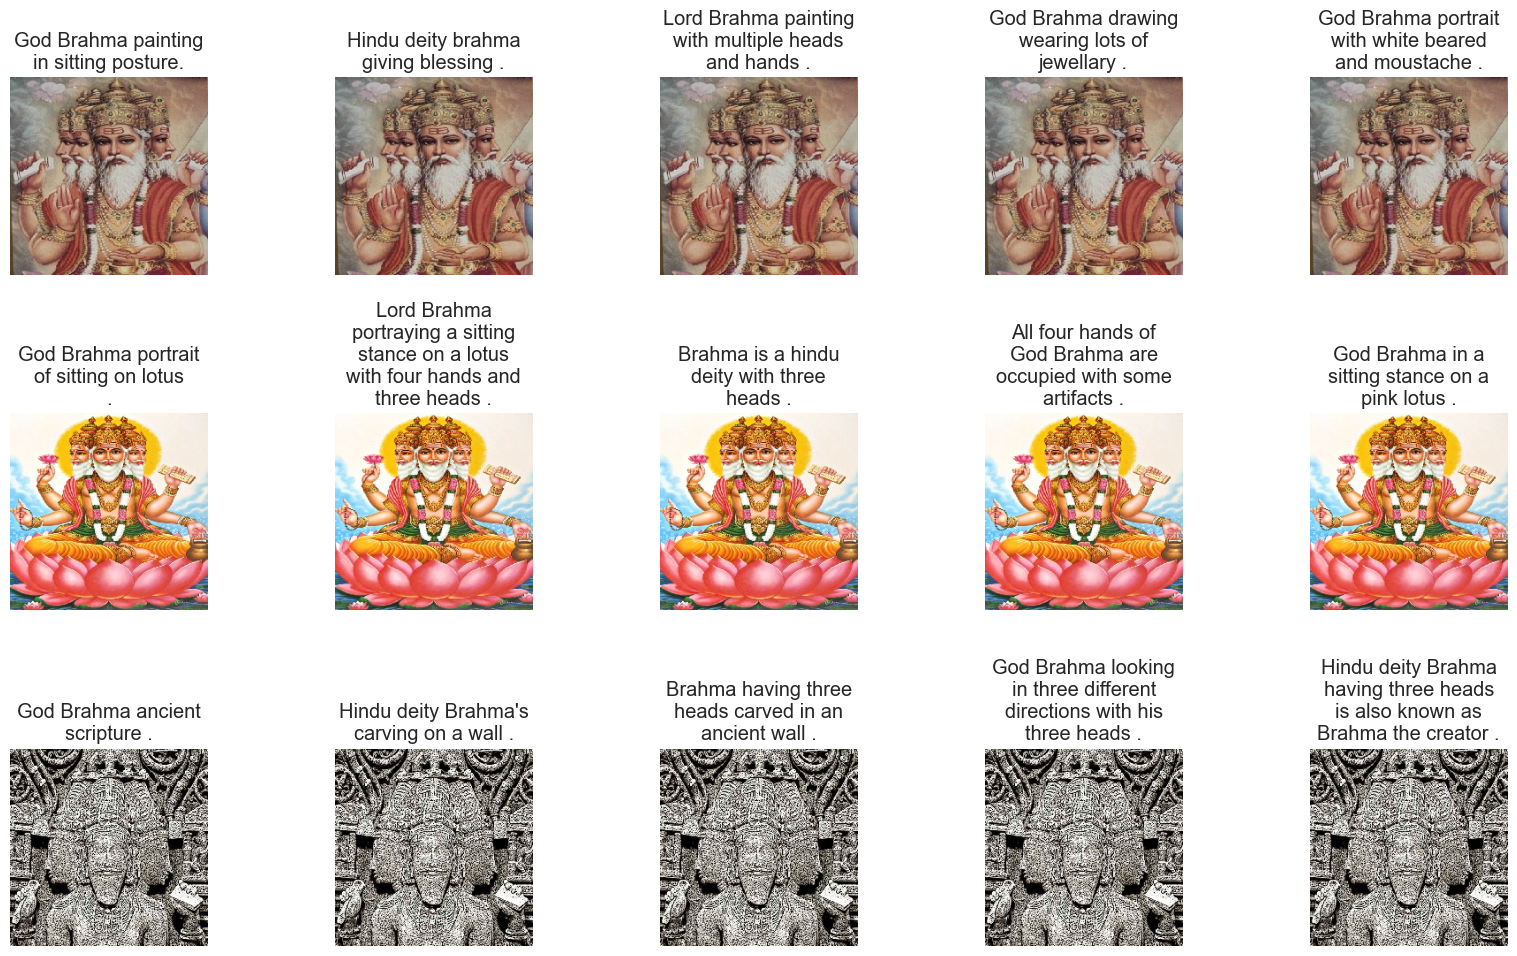

In [67]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image_path = os.path.join(images_directory, temp_df.image[i])
        image = readImage(image_path)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


# Load your DataFrame from a CSV file or another source
temp_df = pd.read_csv(r"C:\Users\Yash Sharma\Desktop\project\DATASET\captions.txt", error_bad_lines=False)

# Continue with the rest of the code
images_directory = r'C:\Users\Yash Sharma\Desktop\project\DATASET\Images'
display_images(temp_df)


In [43]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq startseq god brahma painting in sitting posture. endseq endseq',
 'startseq startseq hindu deity brahma giving blessing endseq endseq',
 'startseq startseq lord brahma painting with multiple heads and hands endseq endseq',
 'startseq startseq god brahma drawing wearing lots of jewellary endseq endseq',
 'startseq startseq god brahma portrait with white beared and moustache endseq endseq',
 'startseq startseq god brahma portrait of sitting on lotus endseq endseq',
 'startseq startseq lord brahma portraying sitting stance on lotus with four hands and three heads endseq endseq',
 'startseq startseq brahma is hindu deity with three heads endseq endseq',
 'startseq startseq all four hands of god brahma are occupied with some artifacts endseq endseq',
 'startseq startseq god brahma in sitting stance on pink lotus endseq endseq']

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 1, 51, 23, 8, 61, 49, 2, 2]

In [45]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.68it/s]


In [46]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [47]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
from tensorflow.keras.utils import plot_model

In [26]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [48]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [59]:
model_name = "model2.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [60]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
2/2 [==============================] - 7s 2s/step - loss: 5.6123 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - 3s 2s/step - loss: 5.2330 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - 3s 2s/step - loss: 5.0533 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 4.8719 - lr: 0.0010
Epoch 5/50
2/2 [==============================] - 3s 2s/step - loss: 4.7438 - lr: 0.0010
Epoch 6/50
2/2 [==============================] - 3s 2s/step - loss: 4.6787 - lr: 0.0010
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 4.5563 - lr: 0.0010
Epoch 8/50
2/2 [==============================] - 3s 2s/step - loss: 4.4564 - lr: 0.0010
Epoch 9/50
2/2 [==============================] - 3s 2s/step - loss: 4.3666 - lr: 0.0010
Epoch 10/50
2/2 [==============================] - 4s 2s/step - loss: 4.2327 - lr: 0.0010
Epoch 11/50
2/2 [==============================] - 4s 2s/step - loss: 4.1558 - lr: 0.0010
Epoch 12/50
2/2 [==

Epoch 18/50
2/2 [==============================] - 3s 2s/step - loss: 3.7048 - lr: 0.0010
Epoch 19/50
2/2 [==============================] - 4s 2s/step - loss: 3.6733 - lr: 0.0010
Epoch 20/50
2/2 [==============================] - 4s 2s/step - loss: 3.6033 - lr: 0.0010
Epoch 21/50
2/2 [==============================] - 3s 2s/step - loss: 3.5085 - lr: 0.0010
Epoch 22/50
2/2 [==============================] - 3s 2s/step - loss: 3.4905 - lr: 0.0010
Epoch 23/50
2/2 [==============================] - 3s 1s/step - loss: 3.4079 - lr: 0.0010
Epoch 24/50
2/2 [==============================] - 3s 1s/step - loss: 3.3684 - lr: 0.0010
Epoch 25/50
2/2 [==============================] - 3s 2s/step - loss: 3.4168 - lr: 0.0010
Epoch 26/50
2/2 [==============================] - 3s 2s/step - loss: 3.3006 - lr: 0.0010
Epoch 27/50
2/2 [==============================] - 3s 2s/step - loss: 3.3035 - lr: 0.0010
Epoch 28/50
2/2 [==============================] - 3s 2s/step - loss: 3.2337 - lr: 0.0010
Epoch 29/5

Epoch 35/50
2/2 [==============================] - 3s 2s/step - loss: 3.0149 - lr: 0.0010
Epoch 36/50
2/2 [==============================] - 3s 1s/step - loss: 2.8670 - lr: 0.0010
Epoch 37/50
2/2 [==============================] - 3s 1s/step - loss: 2.8804 - lr: 0.0010
Epoch 38/50
2/2 [==============================] - 3s 1s/step - loss: 2.8825 - lr: 0.0010
Epoch 39/50
2/2 [==============================] - 3s 2s/step - loss: 2.9067 - lr: 0.0010
Epoch 40/50
2/2 [==============================] - 3s 2s/step - loss: 2.8114 - lr: 0.0010
Epoch 41/50
2/2 [==============================] - 3s 2s/step - loss: 2.8123 - lr: 0.0010
Epoch 42/50
2/2 [==============================] - 4s 2s/step - loss: 2.8052 - lr: 0.0010
Epoch 43/50
2/2 [==============================] - 3s 2s/step - loss: 2.7161 - lr: 0.0010
Epoch 44/50
2/2 [==============================] - 3s 2s/step - loss: 2.6340 - lr: 0.0010
Epoch 45/50
2/2 [==============================] - 4s 2s/step - loss: 2.7273 - lr: 0.0010
Epoch 46/5

In [61]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [62]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [63]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [64]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


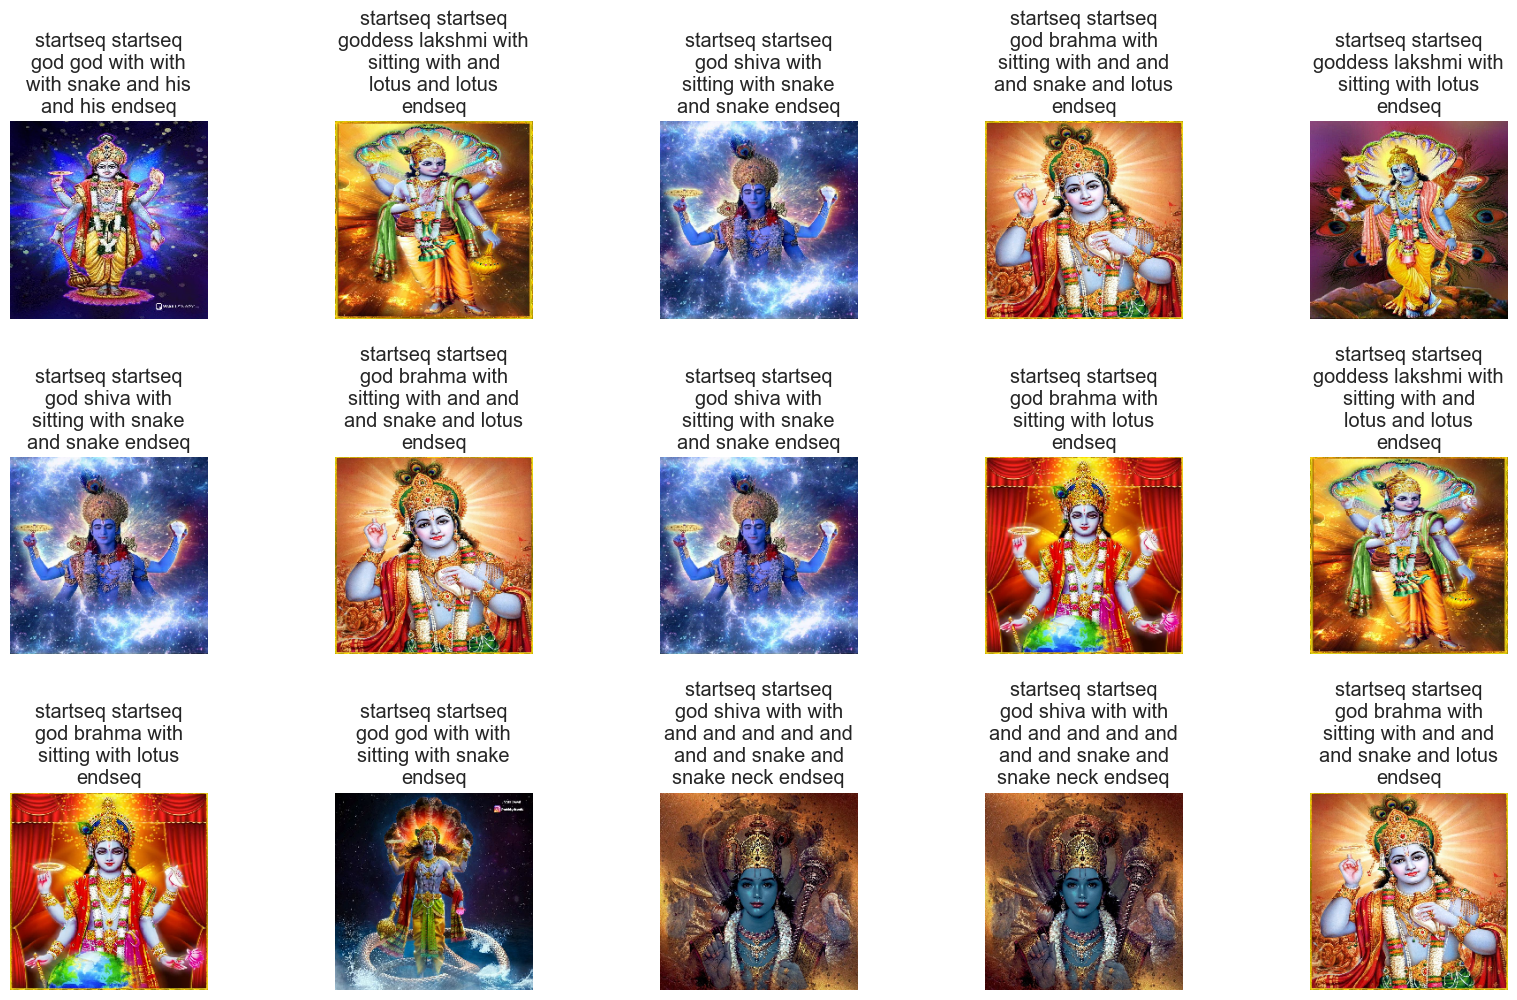

In [68]:
display_images(samples)

In [76]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ... (your existing code)

def calculate_bleu(reference, candidate, n=2):
    reference = [reference.split()]
    candidate = candidate.split()
    smooth = SmoothingFunction().method1  # Define smoothing function

    # Calculate BLEU score with smoothing and specify n-gram
    bleu_score = sentence_bleu(reference, candidate, weights=(1.0 / n,) * n, smoothing_function=smooth)

    return bleu_score


# ... (your existing code)

def evaluate_bleu(model, data, tokenizer, max_length, features):
    bleu1_scores, bleu2_scores = [], []

    for index, record in data.iterrows():
        reference_caption = record['caption']
        predicted_caption = predict_caption(model, record['image'], tokenizer, max_length, features)
        
        bleu1_score = calculate_bleu(reference_caption, predicted_caption, n=1)
        bleu2_score = calculate_bleu(reference_caption, predicted_caption, n=2)
        
        bleu1_scores.append(bleu1_score)
        bleu2_scores.append(bleu2_score)

    average_bleu1 = sum(bleu1_scores) / len(bleu1_scores)
    average_bleu2 = sum(bleu2_scores) / len(bleu2_scores)
    
    return average_bleu1, average_bleu2


# After training, you can evaluate BLEU-1 and BLEU-2 scores on the validation set:
average_bleu1, average_bleu2 = evaluate_bleu(caption_model, test, tokenizer, max_length, features)

# Create a table for BLEU-1 and BLEU-2 scores
table = tabulate({'BLEU-1': [average_bleu1], 'BLEU-2': [average_bleu2]}, headers='keys', tablefmt='pretty')


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


In [77]:
print(table)

+---------------------+---------------------+
|       BLEU-1        |       BLEU-2        |
+---------------------+---------------------+
| 0.33348203204322446 | 0.20552550872371006 |
+---------------------+---------------------+
